<a href="https://colab.research.google.com/github/zeroshima/zeroshima.github.io/blob/main/ErlangC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# New section

# **Workforce planning optimization using Python and ErlangC**
Learn how to find the optimal number of positions needed to manage incoming traffic

Finding the number of positions to use in a queue system has been a study case for a long time now; it has applications in several fields and industries, for example, finding the optimal number of call centers agents, deciding the number of bankers in a support station, network traffic analysis and so on.

There are several methods to analyze this problem; in this article, we will look at how to solve it using Erlang C with Python's Pyworkforce package.

# 1. Queue System
In the most fundamental Erlang C method, we represent the system as a queue with the following assumptions:

There is incoming traffic with a constant rate; the arrivals follow a Poisson process
There is a fixed capacity in the system; usually, only one transaction gets handled by a resource at the time
There is a fixed number of available positions in a time interval
When all the positions have a total capacity, there is an infinite queue length where the requests wait for a position to be free.
An exponential distribution describes the holding times in the queue
There is no dropout from the queue.
A queue system with these characteristics may look like this:

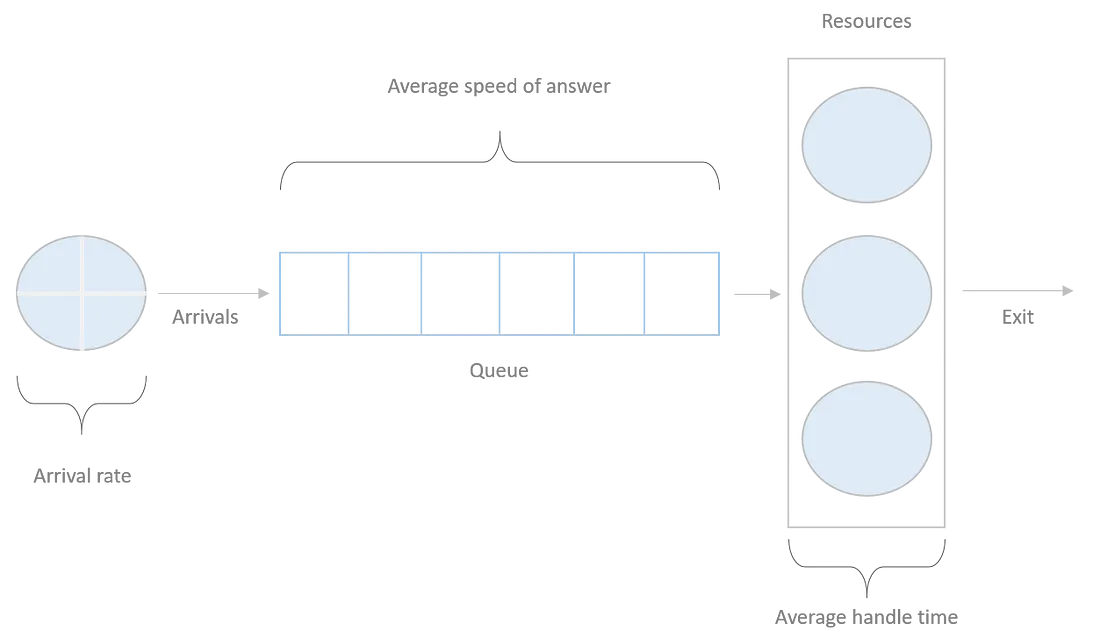

In this representation, we can see several measures that will help us to describe the system; here there are their definitions and how we are going to call them from now on:

* **Transactions**: Number of incoming requests
* **Resource**: The element that handles a transaction
* **Arrival rate**: The number of incoming transactions in a time interval
* **Average speed of answer (ASA)**: Average time that a transaction waits in the queue to be attended by a resource
* **Average handle time (AHT)**: Average time that takes to a single resource to attend a transaction



Other variables are in the diagram, but that is important for the model, those are:

* **Shrinkage:** Expected percentage of time that a server is not available, for example, due to breaks, scheduled training, etc.
* **Occupancy:** Percentage of time that a resource is handling a transaction
* **Service level**: Percentage of transactions that arrives at a resource before a target ASA

The way as Erlang C find the number of resources in this system is by finding the probability that a transaction waits in queue, opposed to immediately being attended, it takes a target ASA and service level and uses the others variables as the system parameters, if you want to know more about the details of Erlang formulation, you can see others resources at the end of the article.

# **2. Python Example**
As an example, we will find the number of agents needed in a call center to handle incoming traffic of calls.

Under the given convention, the resources would be the agent's stations, and the transactions would be the calls under this scenario.

Let's assume that in a time interval of 30 minutes, there is an average of 100 incoming calls, the AHT is 3 minutes, and the expected shrinkage is 30%.

As the call center administrators, we want the average time that a transaction waits in the queue to be 20 seconds and achieve a service level of 80%. We also want to ensure that the maximum occupancy of the agents is not greater than 85%.

To solve this problem, we will use Pyworkforce, a python package for workforce management, schedule, and optimization problems, so let's install it. Using a virtual env is advised.

In [5]:
!pip install pyworkforce



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 50.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.6/311.6 kB 28.6 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.14.0 requires protobuf<4.21,>=3.20.3, but you have protobuf 4.24.4 which is incompatible.


The use of this package is very straightforward; we import ErlangC and initialize the class with the given parameters, then we use the method "required_positions" to find the minimum number of resources to handle the transactions. Take into account that the class expects all the time variables to be in minutes:

In [6]:
from pyworkforce.queuing import ErlangC

erlang = ErlangC(transactions=100, asa=20/60, aht=3, interval=30, shrinkage=0.3)

requirements = erlang.required_positions(service_level=0.8, max_occupancy=0.85)
print(requirements)

{'raw_positions': 14, 'positions': 20, 'service_level': 0.8883500191794669, 'occupancy': 0.7142857142857143, 'waiting_probability': 0.1741319335950498}


What this dictionary gives us is:

**raw_positions**: Number of positions found assuming shrinkage = 0

**positions**: Number of positions found taking the shrinkage provided by the user

**service_level**: The expected percentage of transactions that don't wait in the queue longer than the target ASA

**occupancy**: The expected occupancy that the system is going to have

**waiting_probability**: The probability that a transaction waits in queue

**Note**: The example modeled the system in a time interval of 30 minutes. The Erlan C assumptions may apply; if you want to extend the time interval, you may use the Erlang C several times with the parameters of each interval.

# **3. Running multiples Erlang C**
If you want to try different parameters simultaneously, pyworkforce comes with a MultiErlangC class, which allows you to define a set of parameters to iterate over.

First, create a grid of parameters; it must be a dict, and each parameters options must be in an iterable, as a list.

Then MultiErlangC is going to use the ErlangC method with all possible combinations of the parameters provided.

For example, if the grid has three options of transactions values and two shrinkage options, there will be six different models.

If you have a vast grid, you can also use the parameter "n_jobs" to control the concurrently running jobs, "-1" means using all the available CPUs in the computer.

For this example, lets only try three different options of service levels:

In [28]:
from pyworkforce.queuing import MultiErlangC

param_grid = {"transactions": [100], "interval": [30], "aht": [3,6], "asa": [20 / 60], "shrinkage": [0.3]}
multi_erlang = MultiErlangC(param_grid=param_grid, n_jobs=-1)

required_positions_scenarios = {"service_level": [0.75, 0.85, 0.9], "max_occupancy": [0.8]}

positions_requirements = multi_erlang.required_positions(required_positions_scenarios)
print("positions_requirements: ", positions_requirements)

positions_requirements:  [{'raw_positions': 13, 'positions': 19, 'service_level': 0.7955947884177831, 'occupancy': 0.7692307692307693, 'waiting_probability': 0.285270453036493}, {'raw_positions': 14, 'positions': 20, 'service_level': 0.8883500191794669, 'occupancy': 0.7142857142857143, 'waiting_probability': 0.1741319335950498}, {'raw_positions': 15, 'positions': 22, 'service_level': 0.9414528428690223, 'occupancy': 0.6666666666666666, 'waiting_probability': 0.10204236700798798}, {'raw_positions': 25, 'positions': 36, 'service_level': 0.8416119006021436, 'occupancy': 0.8, 'waiting_probability': 0.20910282659883667}, {'raw_positions': 26, 'positions': 38, 'service_level': 0.8972494613323054, 'occupancy': 0.7692307692307693, 'waiting_probability': 0.14339992844892324}, {'raw_positions': 27, 'positions': 39, 'service_level': 0.9348874500068123, 'occupancy': 0.7407407407407407, 'waiting_probability': 0.09606318958311354}]


If you like the output in a tabular format, you can use pandas, for example:

In [29]:
df = pd.DataFrame(positions_requirements)
print(df)

   raw_positions  positions  service_level  occupancy  waiting_probability
0             13         19       0.795595   0.769231             0.285270
1             14         20       0.888350   0.714286             0.174132
2             15         22       0.941453   0.666667             0.102042
3             25         36       0.841612   0.800000             0.209103
4             26         38       0.897249   0.769231             0.143400
5             27         39       0.934887   0.740741             0.096063
